<h1 style="color:blue">Praktikum 12. </h1>

<h3 style="color:blue">Dokumentide vektoresitus, klasterdamine ja visualiseerimine. Teemade modelleerimine, TF-IDF. Optilise tekstituvastuse katsetamine</h3>

Käesolevas praktikumis uurime, kuidas tekstidokumente automaatselt liigitada ning leida neis kajastatavaid teemasid. Selleks vaatame kõigepealt tekstiandmete viimist vektorkujule, vektoritevahelise kauguse leidmist, seejärel tekstide automaatset klasterdamist, tulemuste visualiseerimist ning tekstides kajastatavate teemade tuvastamist. Boonusmaterjal käsitleb aga hoopis optilist tekstituvastamist.

## Dokumentide klasterdamine

Dokumendi-tasemel tekstide liigitamisel eristatakse sageli kaht lähenemist: klassifitseerimist ja klasterdamist. _Klassifitseerimise_ puhul on meil juba olemas eeldefineeritud klassid, mille alla dokumendid tuleb liigitada, ning on olemas (või luuakse) treeningkorpus, kus selline liigitamine on (enamasti käsitsi) teostatud. Seega klassifitseerimise eesmärgiks on õppida treeningkorpuse põhjal automaatselt uusi dokumente liigitama.  _Klasterdamise_ puhul on olemas korpus, milles soovitakse dokumendid sarnasuse alusel gruppidesse jagada, ning tüüpiliselt pole teada võimalike gruppide arv ega ka see, kuidas gruppe võiks nimetada. Klasterdada võib aga ka siis, kui klasside arv ja sisu on eelnevalt teada, aga nt puudub märgendatud korpus - võib-olla kukuvad tekstid ise õigetesse klastritesse. Seega on klasterdamine tavaliselt orienteeritud korpuse uurimisele (tahame teada, milliseid sarnasusi seal võib olla), klassifitseerimine aga rakendusliku orientatsiooniga (tahame luua tööriista, mille abil saaks automaatselt liigitada uusi dokumente).

Selles praktikumis käsitletavad sarnasuse leidmise meetodid sobivad tegelikult mõlema lähenemise puhul. Dokumentide sarnasus leitakse siin sõnade esinemissageduste järgi ehk eeldatakse, et sarnase sisuga dokumendid peavad olema sarnased ka sõnavaraliselt / leksikaalselt.

Praktikumi näidete käivitamiseks ja ülesannete lahendamiseks kasutame teeki [scikit-learn](https://scikit-learn.org), mille saab installida tavapäraselt käsuga ```conda install scikit-learn```   

### Sõnade vektoresitused ja dokument-sõna maatriks

Matemaatilistele meetoditele meeldivad struktureeritud arvandmed: _vektorid_ (lihtsustatult öeldes: arvude järjendid) ja _maatriksid_ (lihtsustatult öeldes: arvude tabelid). Seetõttu tuleb enne statistiliste / masinõppe meetodite kasutuselevõtmist leida viis, kuidas "teisendada" oma tekstilised andmed arvandmeteks.

Tekstide automaatsel klassifitseerimisel või klasterdamisel viiakse analüüsitava korpuse dokumendid _vektorkujule_ ehk:

   1. luuakse iga korpuse sõna kohta _vektor_ (arvude "järjend"), mille iga positsioon kirjeldab sõna esinemist ühes korpuse dokumendis;
   2. kõigi sõnade vektoritest pannakse kokku _maatriks_ (arvude "tabel"), mille järgi saab leida nii üksiksõnade esinemismustreid kui ka dokumenti iseloomustava sõnavaramustri. 

Sarnasuste leidmisel tuginevadki statistilised meetodid maatriksile ning tekstide omadused, mis maatriksis ei kajastu (nt sõnade omavaheline järjekord, lausestus, süntaks vms) tulemust otseselt ka ei mõjuta. Siiski lisatakse masinõppelähenemiste puhul maatriksisse peale sõnaesinemiste ka muud informatsiooni dokumentide kohta (_a la_ dokumendi pikkus sõnades, loomise aeg). Käesolevas praktikumis vaatleme maatrikseid aga kõige tavapärasemal klasterdamiseks kasutataval kujul ehk _dokument-sõna_ maatriksitena.

Järgnevalt uurime samm-sammult, kuidas toimub dokument-sõna maatriksi loomine. Selleks laeme kõigepealt sisse ( _json_-kujul ) testkorpuse tekstid. Talletame ka failinimed, et meil oleks hiljem selge ülevaade, milline tekst millisest failist pärines:

In [1]:
# 1) Andmete sisselugemine failidest
import os, os.path
from estnltk.converters import json_to_text

input_dir = '1_testkorpus'

texts     = []
filenames = []
for filename in sorted(os.listdir(input_dir)):
    full_filename = os.path.join(input_dir, filename)
    text = json_to_text(file=full_filename)
    # Loeme sisse tekstid (sõned) ja tekstide nimed
    texts.append(text.text)
    filenames.append(filename)

Edasi kasutame teeki [scikit-learn](https://scikit-learn.org/stable/). Klass [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn-feature-extraction-text-countvectorizer) võimaldab luua sõnavektoreid, mille iga positsioon kirjeldab sõna esinemissagedust ühes dokumendis. Klassi initsialiseerimisel on võimalik täpsustada mitmeid teksti eeltöötluse samme, nt kas sõnad tuleks teisendada väiketähelisteks (vaikimisi: jah), kuidas (millise meetodi abil) jagada tekst sõnadeks ning millised sõnad on nn _stopp_-sõnad, mis tuleks välja jätta. 

Esialgu huvitab meid see, et tekst oleks sõnestatud, kasutades eesti keele sõnestusvahendeid. Seega loome meetodi, mis saab sisendiks sõne, sõnestab selle EstNLTK abil ning tagastab sõnade järjendi. Ning _CountVectorizer_-i loomisel täpsustame, et sõnestamiseks tuleks kasutada just seda meetodit:

In [2]:
# 2) Vektoriseerija loomine
from sklearn.feature_extraction.text import CountVectorizer
from estnltk import Text

# Meetod teksti sõnestamiseks estnltk abil
def tokenize_with_estnltk( input_string ):
    return Text(input_string).tag_layer(['words']).words.text

# Loome uue vektoriseerija, mis jagab tekstid sõnadeks estnltk abil:
vectorizer = CountVectorizer(tokenizer = tokenize_with_estnltk, token_pattern=None)

Nüüd saamegi kasutada `vectorizer`-it dokument-sõna maatriksi loomiseks. Selleks anname talle sisendiks järjendi analüüsitavatest dokumentidest (sisuliselt: järjend sõnedest), mille põhjal luuakse maatriks:

In [3]:
# 3) Andmete viimine vektor-kujule
matrix = vectorizer.fit_transform(texts)

Võime uurida maatriksi (tabeli) mõõtmeid atribuudi `shape` abil:

In [4]:
matrix.shape

(10, 2128)

Seega on meie tabelis 10 rida (erinevate tekstide arv meie korpuses) ning 2128 veergu (erinevate sõnade arv).

Maatriksi põhjal saame ka uurida, millised sõnad / sõned korpuses esinesid:

In [5]:
# uurime kogutud sõnavara
vocab = vectorizer.get_feature_names_out()
# sõnu on palju; kuvame 100 esimest ülevaateks
vocab[:100]

array(['!', '"', '&', '(', ')', ',', '-', '.', '..', '...', '/', '10%',
       '10.', '150', '16', '16.', '17', '190', '1990.', '1991.', '1999.',
       '20 .', '20-ruutmeetrine', '200', '2000', '22.', '25-tonnise',
       '25.', '26.', '26.04', '28a', '30', '300', '32.', '350', '4',
       '400', '4000', '48', '5', '5000', '58kg', '63-aastane', '8', '800',
       '9.', ':', ';', '?', 'aasta', 'aastakümmet', 'aastal', 'aastane',
       'aastast', 'aastat', 'aastatel', 'abba', 'abi', 'abihoone',
       'abiturientide', 'aega', 'aegadel', 'aegajalt', 'aeglaselt',
       'aeroobikatreener', 'after', 'aga', 'agne', 'ahistavad', 'aidata',
       'ainjärv', 'ainsas', 'ainuke', 'ainult', 'ainus', 'ainuüksi',
       'aitab', 'aitas', 'aitavad', 'ajada', 'ajaks', 'ajal', 'ajalugu',
       'ajasin', 'ajavahemikuks', 'akadeemia', 'aken', 'akende', 'aknad',
       'aknaklaase', 'aknaklaasid', 'aktsiaseltsi', 'aktusele', 'aladele',
       'aladelt', 'alakoholi', 'alal', 'alanenud', 'alates', 'alati

Konkreetsete sõnasageduste kättesaamiseks tuleb uurida maatriksi lahtreid. Maatriks on indekseeritud täisarvude järgi ning õige lahtri leidmiseks peame teadma vastavusi failinimede ja reaindeksite vahel ning sõnade ja veeruindeksite vahel. 

Mõlemad vastavused on meil tegelikult juba olemas. Andmete sisselugemisel salvestasime failinimed muutujasse `filenames`. Ning `vocab` sisaldab kõiki tekstis esinenud sõnu, samas järjekorras, nagu on maatriksi veerud.

In [6]:
# Leiame, mitu korda esineb sõna 'ja' esimeses tekstis

# 1) esimese faili nimi:
print(filenames[0])

# 2) otsime maatriksist lahtri, mis vastab esimesele failile ning sõnale 'ja':
print(matrix[0, list(vocab).index('ja')])

aja_EPL_1999_12_30.json
16


Seega võime teha väikese programmi, mis aitab uurida etteantud sõnade esinemissagedust korpuse failide lõikes:

In [7]:
# Leiame etteantud sõnade listi põhjal, mitu korda esinesi iga sõna kõigis korpuse tekstides
words_of_interest = ['ja', 'ning', 'siis', 'omapäraselt']
vocab_list = list(vocab)

for word in words_of_interest:
    for fid, fnm in enumerate(filenames):
        occurrence = matrix[fid, vocab_list.index(word)]
        if occurrence:
            print(' Sõna "'+word+'" esineb failis ',fnm,' ',occurrence,' korda.')
    print()

 Sõna "ja" esineb failis  aja_EPL_1999_12_30.json   16  korda.
 Sõna "ja" esineb failis  aja_EPL_2001_06_18.tasak.json   12  korda.
 Sõna "ja" esineb failis  aja_pm_1999_08_13__40.json   4  korda.
 Sõna "ja" esineb failis  aja_pm_1999_08_13__42.json   7  korda.
 Sõna "ja" esineb failis  aja_sloleht_1999_08_13__36.json   9  korda.
 Sõna "ja" esineb failis  aja_sloleht_1999_08_13__68.json   1  korda.
 Sõna "ja" esineb failis  ettenten_arhiiv_koolielu_ee__470699.json   13  korda.
 Sõna "ja" esineb failis  ettenten_bio_edu_ee__442509.json   10  korda.
 Sõna "ja" esineb failis  ettenten_www_kliinik_ee__447481.json   17  korda.
 Sõna "ja" esineb failis  ettenten_www_poogen_ee__145074.json   12  korda.

 Sõna "ning" esineb failis  aja_EPL_1999_12_30.json   3  korda.
 Sõna "ning" esineb failis  aja_EPL_2001_06_18.tasak.json   2  korda.
 Sõna "ning" esineb failis  aja_pm_1999_08_13__42.json   3  korda.
 Sõna "ning" esineb failis  aja_sloleht_1999_08_13__36.json   1  korda.
 Sõna "ning" esineb f

_Hõredad andmed_. Kui luua sõnade esinemissageduste tabel, siis võib sealt hakata silma nullidega lahtrite rohkus. Üldine tendents tekstiandmete puhul ongi see, et dokument-sõna maatriks tuleb hästi suur (antud juhul: 10 x 2128 lahtrit) ja sisaldab palju nulle. Kui hoiaksime sellist maatriksit tavalises Pythoni kahekordses listis, siis oleks suur osa infost sõnade _mitte-esinemise_ kohta ning ainult väike osa nende _esinemise_ kohta. See oleks aga üsna ebaefektiivne mälukasutus, kuivõrd on juba ette teada, et kõige olulisem info puudutab just sõnade esinemist ning et enamik sõnu on korpustes madala levikuga (st esinevad vaid vähestes dokumentides). Seetõttu tagastabki `CountVectorizer` vaikimisi nn hõreda maatriksi, kuhu pole salvestatud nulle, vaid ainult erinevused "nullide meres". Suurte korpuste korral võimaldab see kokku hoida sadu megasid mäluruumi (lähemalt on selle kohta kirjutatud [siin](https://github.com/DARIAH-DE/tatom/blob/develop/source/working_with_text.rst#creating-a-document-term-matrix) ja [siin](http://scikit-learn.org/stable/modules/feature_extraction.html#sparsity)).

### Dokumentide võrdlemine

Nüüd, mil korpuse dokumendid on viidud vektorite kujule, saame nendel rakendada matemaatilisi meetodeid ning uurida nende sarnasust. 

#### Eukleidese kaugus

Üheks sageli katsetatavaks meetodiks on Eukleidese kaugus. Lihtsamal juhul, kui meil on tegemist 2-mõõtmelise (eukleidilise) ruumiga, saame vektoreid ette kujutada kui samast alguspunktist lähtuvaid "jooni" tasandil, ning eukleidiliseks kauguseks on siis kahe "joone" lõpp-punktide vahele tõmmatud (ja neid "kolmnurgaks" ühendava) joone pikkus. Meie andmed on küll keerulisema struktuuriga -- tegemist on _n_-mõõtmeliste vektoritega (kus _n_ on sõnade arv korpuses), mida pole just eriti lihtne visuaalselt ette kujutada. Aga matemaatiliselt saame kauguse 2-mõõtmelises eukleidilises ruumis üldistada [kauguseks _n_-mõõtmelises ruumis](https://et.wikipedia.org/wiki/Kaugus#Kaugus_eukleidilistes_ruumides) ning teha vastavad arvutused. Teek `sklearn` pakub selleks välja ka mugava funktsiooni:

In [8]:
from sklearn.metrics.pairwise import euclidean_distances

eucl_dist = euclidean_distances(matrix)

Tulemuseks saame samuti tabeli (täpsemalt: `numpy` järjenditest koosneva järjendi), aga seekord on tabeli mõõtmed märksa väiksemad:

In [9]:
eucl_dist.shape

(10, 10)

Sisuliselt on tabelis dokumentidevahelised kaugused korpuses, sh ka iga dokumendi kaugus iseendast.

In [10]:
# Dokumentide 1 ja 0 vaheline kaugus
eucl_dist[1,0]

56.39148871948674

Tabelist ülevaate saamiseks võime kasutada `pandas.DataFrame`-i:

In [11]:
import numpy as np

# Ümardame väärtused (1 koht peale koma)
rounded = np.round(eucl_dist, 1)

# Kuvame pandase abil tabelina:
from pandas import DataFrame
eucl_dist_df = DataFrame( rounded )
eucl_dist_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,56.4,66.3,67.1,66.5,72.7,63.8,64.1,65.4,80.3
1,56.4,0.0,61.8,51.9,54.3,77.1,57.6,62.4,51.0,50.8
2,66.3,61.8,0.0,39.8,35.4,32.7,33.3,29.8,44.6,66.2
3,67.1,51.9,39.8,0.0,40.0,55.3,41.8,43.2,43.5,53.4
4,66.5,54.3,35.4,40.0,0.0,54.9,41.4,42.6,47.5,59.0
5,72.7,77.1,32.7,55.3,54.9,0.0,38.7,29.2,54.8,83.5
6,63.8,57.6,33.3,41.8,41.4,38.7,0.0,29.8,40.5,62.9
7,64.1,62.4,29.8,43.2,42.6,29.2,29.8,0.0,42.5,69.5
8,65.4,51.0,44.6,43.5,47.5,54.8,40.5,42.5,0.0,54.0
9,80.3,50.8,66.2,53.4,59.0,83.5,62.9,69.5,54.0,0.0


7. praktikumist mäletame, et sellist sarnasuste maatriksit on lihtne visualiseerida *heatmap*'ina:

In [12]:
import seaborn as sns

<Axes: >

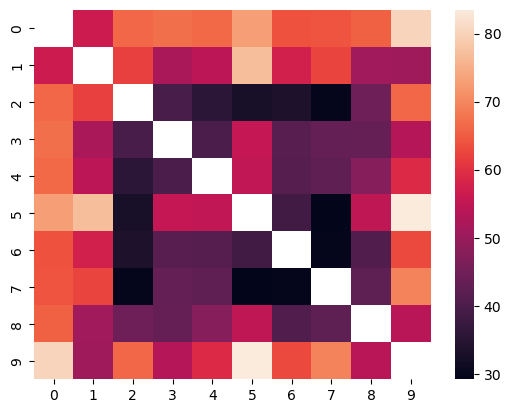

In [13]:
sns.heatmap(eucl_dist_df[eucl_dist_df > 0])

Millised dokumendid on kõige sarnasemad, st kõige väiksema kaugusega? Tabeli diagonaalil võib märgata 0.0 väärtuseid, aga need ei loe, kuna märgivad dokumentide kauguseid iseendast. Seega meid huvitab väikseim nullist erinev arv, mille saab "automaagiliselt" kätte nii:

In [14]:
# Minimaalse väärtuse leidmine DataFrame'ist
min_value = eucl_dist_df[eucl_dist_df > 0].min().min()
min_value

29.2

Nüüd saame minimaalse väärtuse ka tabelis värvida / esile tuua:

In [15]:
import math

# Funktsioon, mis omistab tabeli lahtrile kollase värvi, kui väärtus s on piisavalt lähedal min_value-le
color_fun = lambda s: 'background-color: yellow' if math.isclose(s, min_value, rel_tol=1e-5) else ''

# Rakendame funktsioon oma tabelil
eucl_dist_df.style.map(color_fun)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,56.400000,66.300000,67.100000,66.500000,72.700000,63.800000,64.100000,65.400000,80.300000
1,56.400000,0.000000,61.800000,51.900000,54.300000,77.100000,57.600000,62.400000,51.000000,50.800000
2,66.300000,61.800000,0.000000,39.800000,35.400000,32.700000,33.300000,29.800000,44.600000,66.200000
3,67.100000,51.900000,39.800000,0.000000,40.000000,55.300000,41.800000,43.200000,43.500000,53.400000
4,66.500000,54.300000,35.400000,40.000000,0.000000,54.900000,41.400000,42.600000,47.500000,59.000000
5,72.700000,77.100000,32.700000,55.300000,54.900000,0.000000,38.700000,29.200000,54.800000,83.500000
6,63.800000,57.600000,33.300000,41.800000,41.400000,38.700000,0.000000,29.800000,40.500000,62.900000
7,64.100000,62.400000,29.800000,43.200000,42.600000,29.200000,29.800000,0.000000,42.500000,69.500000
8,65.400000,51.000000,44.600000,43.500000,47.500000,54.800000,40.500000,42.500000,0.000000,54.000000
9,80.300000,50.800000,66.200000,53.400000,59.000000,83.500000,62.900000,69.500000,54.000000,0.000000


Teine viis seda teha: teeme tsükli üle tabeli ning kasutame vahemuutujat minimaalse väärtuse ülesleidmiseks. Ühtlasi leiame ka üles vastavad rea- ja veeruindeksid (millised dokumendid olid kõige sarnasemad):

In [16]:
# Leiame, millised dokumendid on kõige sarnasemad eukleidese kauguse järgi
min_dist = eucl_dist[1,0]
min_xid = 0
min_yid = 0
for xid, x in enumerate(eucl_dist):
    for yid, y in enumerate(x):
        if xid != yid and y < min_dist:
            min_dist = y
            min_xid = xid
            min_yid = yid
print(' Kõige sarnasemad ( kaugus',min_dist,') on',filenames[min_xid],'ja',filenames[min_yid])

 Kõige sarnasemad ( kaugus 29.24038303442689 ) on aja_sloleht_1999_08_13__68.json ja ettenten_bio_edu_ee__442509.json


Uurime ka mõlema faili/dokumendi alguseid:

In [17]:
print('-'*50)
print(filenames[min_xid], ':', texts[min_xid][:300])
print('-'*50)
print(filenames[min_yid], ':', texts[min_yid][:300])
print()

--------------------------------------------------
aja_sloleht_1999_08_13__68.json : Tervisekaupade seas tõotab värskeimaks moeks saada tervist kohendavate maiuste tarvitamine .

Analüüsifirma Datamonitor hinnangul hakkavad inimesed juba üsna varsti maiustama näiteks vitamiinidega üle puistatud komme , kuna muidu jääb vitamiinide osa toidusedelis liiga väikeseks .

Vitamiinide , min
--------------------------------------------------
ettenten_bio_edu_ee__442509.json : Rohevint

Rohevint on varblasest veidi suurem rohekaskollane (isaslind) või hallikaskollane (emaslind) tüseda koonilise nokaga laululind. Vaatamata pisut jässakale kehakujule on rohevindi liigutused osavad ja lend kiire. Rahuliku iseloomu tõttu võib ta õige kaua ühel kohal püsida ja ümbrust silmitse



### Ülesanne 1. Kattuvused sõnavaras (0,5 p)

Eelmise katse väljundit (kahe "kõige sarnasema" dokumendi alguseid, aga ka sisusid) uurides on üsna raske aru saada, miks meetod pakub, et tegemist on sarnaste dokumentidega. Et probleemi lähemalt uurida, looge funktsioon, mis saab argumentideks dokument-sõna-maatriksi (`matrix`), sõnaloendi (`vocab`) ja kahe dokumendi (maatriksi rea) indeksid (täisarvud `x` ja `y`), ning leiab ja tagastab sõnad, mis esinesid mõlemas dokumendis, koos vastavate sõnasagedustega mõlemas dokumendis. Tulemused võib vormistada nt ennikutena:

```python
>> common_words(matrix, vocab, 1, 2)
[('lennujaama', 1, 2), ('tallinna', 3, 4), ... ]
```
Leidke funktsiooni abil kahe kõige sarnasema dokumendi sõnavaraline kattuvus.

#### Koosinus-sarnasus 
Eukleidese kauguse rakendamisel tekstide võrdlemisel on üks iseärasus: kauguseid mõjutab võrreldavate dokumentide pikkus. Seega,  kui kaks dokumenti kirjutavad samal teemal (kasutavad sarnast sõnavara), aga on pikkuse poolest väga erinevad (nt üks on lühike uudisnupp ning teine pikk arvamuslugu), siis Eukleidese kaugus ei pruugi neid kahte dokumenti kõige sarnasemateks lugeda. Pigem võib juhtuda, et "sarnasteks" kujunevad pikkuse poolest sarnased dokumendid.

Sellest probleemist saame üle, kui kasutame vektorite võrdlemise teistsugust meetodit: **koosinus-sarnasust** (ingl _cosine similarity_). Tuleme tagasi 2-mõõtmelise ruumi näite juurde. Nagu eelnevalt, nii ka nüüd on vektorid ühest ja samast punktist algavad "jooned" tasandil ja meid huvitab nende joonte "sarnasus". Aga seekord hülgame joonte lõpp-punktide vahelise kauguse (mis sõltub joonte pikkusest) ning mõõdame vaid kahe "joone" vahelist nurka. Seda teebki koosinus-sarnasus. Kui läheme 2-mõõtmelisest ruumist jälle _n_-mõõtmelisse ruumi dokumentide-vahelist sarnasust leidma, siis hakkab tulemust (vektorite-vahelist nurka) mõjutama mitte niivõrd kattuvate sõnade sagedus, kuivõrd üleüldine kattuvate sõnade arv (mida rohkem erinevaid kattuvaid sõnu, seda väiksem nurk -- isegi kui kattuvad sõnad ise on vähesagedased).

Rangelt võttes on `cosine_similarity` sarnasuse mõõdik ning tagastab 0 ja 1 vahele jääva väärtuse (1 == maksimaalne sarnasus / identsus, 0 == maksimaalne erinevus). Et meie tulemused oleks enam-vähem võrreldavad Eukleidese kauguse omadega, peame sarnasused teisendama kaugusteks (ehk siis läbi viima tehted: _kaugus_ = 1 - _sarnasus_). Selleks on teegis `sklearn` olemas eraldi funktsioon:

In [18]:
from sklearn.metrics.pairwise import cosine_distances

cos_dist = cosine_distances(matrix)
cos_dist

array([[0.        , 0.26014779, 0.53246741, 0.48151069, 0.47592839,
        0.68264473, 0.4747659 , 0.47165526, 0.45829498, 0.48368046],
       [0.26014779, 0.        , 0.30864234, 0.23275668, 0.26013435,
        0.54497077, 0.26688999, 0.29567633, 0.22263921, 0.18111386],
       [0.53246741, 0.30864234, 0.        , 0.24897073, 0.17921586,
        0.602905  , 0.36268058, 0.39101752, 0.36032217, 0.27762593],
       [0.48151069, 0.23275668, 0.24897073, 0.        , 0.23422336,
        0.54554934, 0.2978718 , 0.30717541, 0.27799142, 0.20009005],
       [0.47592839, 0.26013435, 0.17921586, 0.23422336, 0.        ,
        0.57446101, 0.29855495, 0.30618029, 0.3346192 , 0.26192177],
       [0.68264473, 0.54497077, 0.602905  , 0.54554934, 0.57446101,
        0.        , 0.55508902, 0.56295185, 0.56419528, 0.54755989],
       [0.4747659 , 0.26688999, 0.36268058, 0.2978718 , 0.29855495,
        0.55508902, 0.        , 0.29631177, 0.28359907, 0.26220467],
       [0.47165526, 0.29567633, 0.3910175

In [19]:
# Tulemused ilusa ümardatud arvudega tabelina:
from pandas import DataFrame
DataFrame( np.round(cos_dist, 2) )

,0,1,2,3,4,5,6,7,8,9
0,0.00,0.26,0.53,0.48,0.48,0.68,0.47,0.47,0.46,0.48
1,0.26,0.00,0.31,0.23,0.26,0.54,0.27,0.30,0.22,0.18
2,0.53,0.31,0.00,0.25,0.18,0.60,0.36,0.39,0.36,0.28
3,0.48,0.23,0.25,0.00,0.23,0.55,0.30,0.31,0.28,0.20
4,0.48,0.26,0.18,0.23,0.00,0.57,0.30,0.31,0.33,0.26
5,0.68,0.54,0.60,0.55,0.57,0.00,0.56,0.56,0.56,0.55
6,0.47,0.27,0.36,0.30,0.30,0.56,0.00,0.30,0.28,0.26
7,0.47,0.30,0.39,0.31,0.31,0.56,0.30,0.00,0.30,0.32
8,0.46,0.22,0.36,0.28,0.33,0.56,0.28,0.30,0.00,0.21
9,0.48,0.18,0.28,0.20,0.26,0.55,0.26,0.32,0.21,0.00


Lõpuks leiame, millised on seekord kaks kõige sarnasemat dokumenti:

In [20]:
# Leiame, millised dokumendid on kõige sarnasemad koosinus-sarnasuse järgi
min_dist = cos_dist[1,0]
min_xid = 0
min_yid = 0
for xid, x in enumerate(cos_dist):
    for yid, y in enumerate(x):
        if xid != yid and y < min_dist:
            min_dist = y
            min_xid = xid
            min_yid = yid
print(' Kõige sarnasemad ( kaugus',min_dist,') on',filenames[min_xid],'ja',filenames[min_yid])

 Kõige sarnasemad ( kaugus 0.1792158575339805 ) on aja_pm_1999_08_13__40.json ja aja_sloleht_1999_08_13__36.json


In [21]:
print('-'*50)
print(filenames[min_xid], ':', texts[min_xid][:300])
print('-'*50)
print(filenames[min_yid], ':', texts[min_yid][:300])
print()

--------------------------------------------------
aja_pm_1999_08_13__40.json : KERSTI NEIMAN

Tallinna lennujaamast startinud täislastiga transpordilennuk hirmutas üleeile umbes saja meetri kõrguselt üle pealinna elamurajoonide lennates inimesi , pannes Nõmme ja Tondi majad mürast vappuma ja klaasid klirisema .

“ Sellist müra pole ma kunagi elus kuulnud , ei oska isegi öelda 
--------------------------------------------------
aja_sloleht_1999_08_13__36.json : 25-tonnise laadungiga Vene transpordilennuk IL-76 raputas üleeile Nõmme ja Tondi maju ning väristas aknaklaase , sest ei suutnud Tallinna kohal kõrgust võtta . “ Ma ei saanud alguses aru , mis toimus , ” rääkis Nõmmel elav Anvar Samost . “ Toas polnud võimalik rääkida , mürin oli tohutu .
Aknaklaasi



Seekord paistab tulemus palju parem :)

### Ülesanne 2. Sarnase sisuga artiklid (2 p)

Kataloogis `'2_aja_EPL_pm_sloleht'` on kolme ajalehe -- Eesti Päevalehe, Postimehe ja SL Õhtulehe -- artiklid. Katsetage  _koosinus-sarnasust_ ja kolme erinevat eeltöötluse võtet ning leidke SL Õhtulehe artiklitele kõige sarnasemad artiklid. 

Töö tulemusena väljastab programm SL Õhtulehe artiklid (failinimed koos artiklipealkirjadega) ning iga artikli järel kolm kõige sarnasemat artiklit (artiklite failinimed + pealkirjad), igaüks leitud erinevat eeltöötluse võtet kasutades. Eeltöötluse võtted peaksid katma:

   1. Tavalist EstNLTK sõnestamist (maatriksi veergudeks sõnavormid);
   2. Korpuse lemmatiseerimist EstNLTK abil (maatriksi veergudeks sõnalemmad);
   3. Stopp-sõnade (ja/või väga sagedaste sõnade) eemaldamist;

Mõni võte võib ka kombineerida mitut asja eelmisest loetelust. Millisel viisil läheb kõige rohkem sarnaseid artikleid täppi (pealkirjade ja/või artiklite sisu põgusa uurimise järgi otsustades)?

Detaile:

  * Sisendandmed on json formaadis `Text` objektid. Tuletage varasematest praktikumidest meelde, millise EstNLTK meetodiga on neid mugavalt võimalik sisse lugeda; Artiklite `Text` objektid sisaldavad ka metaandmeid, nt `"title"`, `"ajalehenumber"`, `"author"`;
  * Dokumentide viimiseks vektorkujule kasutage klassi [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn-feature-extraction-text-countvectorizer); Eeltöötluse võtete kehtestamine peaks toimima läbi selle klassi parameetrite muutmise;
  * Dokumentide-vaheliste kauguste maatriksite loomiseks kasutage funktsiooni [cosine_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances); Iga eeltöötluse võtte rakendamisel luuakse uus kauguste maatriks;
  * Et koodis oleks vähem kordamist, tuleks luua ka funktsioon, mis saab sisendiks kauguste maatriksi ja dokumendi indeksi ning leiab maatriksi põhjal etteantud dokumendile kõige sarnasema dokumendi (indeksi);

### Tekstide klasterdamine ja visualiseerimine

Kui meil on teada dokumentide sarnasused / kaugused paarikaupa (ning just selline info on meie kauguste maatriksi(te)s), siis võime paarikaupa sarnasuste leidmise ideed üldistada ning otsida sarnasusi suuremate gruppide vahel. **Klasterdamise** eesmärgiks ongi moodustada korpuses olevatest dokumentidest grupid ehk _klastrid_ (sh on lubatud ka ühest dokumendist koosnevad klastrid -- kui mingile dokumendile ei leidugi ühtegi teist sarnast dokumenti).

Klasterdamise puhul on üheks keeruliseks küsimuseks, kuhu tõmmata piir sarnaste ja mitte-sarnaste dokumentide vahel. Ehk siis: alates millisest kauguse väärtusest tuleks dokumendid kindlasti paigutada erinevatesse klastritesse. Sellele probleemile võib läheneda erinevalt. Klasterdamise algoritm [_K-Means_](http://scikit-learn.org/stable/modules/clustering.html#k-means) eeldab, et (võimalike) klastrite arv on juba eelnevalt välja selgitatud (nt andmete uurimise teel) ning antakse programmile ette, programmi ülesandeks on seejärel moodustada täpselt etteantud arv klastreid. Algoritm [_DBSCAN_](http://scikit-learn.org/stable/modules/clustering.html#dbscan) nõuab kasutajalt klastrite tihedust kirjeldavate parameetrite määramist (kui suur peab olema sarnaste dokumendite naabruskond ning maksimaalne lubatud kaugus, et võiks moodustada klastri) ning moodustab klastrid ainult (kauguste poolest) tihedalt koos paiknevatest dokumentidest.

Praktikas, kui me alles alustame korpuse uurimisega, ei pruugi meil olla selget ülevaadet sellest, kui palju ja milliseid klastreid saab tekstidest moodustada. Seega oleks kõige parem selline lähenemine, mis annab ülevaate võimalikest klastritest, ent ei nõua selget piiride tõmbamist klastrite vahele. Ning sellist lähenemist pakub **hierarhiline klasterdamine**.

[Hierarhilise klasterdamise](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) käigus moodustatakse dokumentidest hierarhia (puu-struktuur), mille saab visualiseerida dendrogrammina ning millelt saab välja lugeda infot kõigi dokumentide klastri-kuuluvuse kohta. 

Käesolevas praktikumis kasutame hierarhiliseks klasterdamiseks teegi `scipy` vahendeid (kui teil on `sklearn` juba installitud, peaks olemas olema ka `scipy`, kuna `sklearn` sõltub sellest).

Enne klasterdamist tuleb aga teha veel üks andmeteisendus.
Nimelt, kui teegis `sklearn` olid meil kaugused salvestatud 2-mõõtmelisse andmestruktuuri, siis teegis `scipy` hoitakse kauguseid nn tihendatud (ingl _condensed_) maatriksis, mis on 1-mõõtmeline andmestruktuur.
Seega `sklearn` kujul maatriks ei sobi ja kaugused tuleb uuesti arvutada, kasutades `scipy` funktsiooni [`pdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html):

In [22]:
from scipy.spatial.distance import pdist
# Arvutame (koosinus)kauguse scipy abil, tulemuseks "condensed" kaugusmaatriks
condensed_dist_matrix = pdist( matrix.toarray(), 'cosine')

Klasterdamist teostab meetod `linkage` ning tulemused tagastatakse nn aheldusmaatriksi kujul:

In [23]:
from scipy.cluster.hierarchy import linkage

# Teostame klasterdamise, tulemuseks saame nn aheldusmaatriksi
linkage_matrix = linkage( condensed_dist_matrix )

In [24]:
linkage_matrix

array([[ 2.        ,  4.        ,  0.17921586,  2.        ],
       [ 1.        ,  9.        ,  0.18111386,  2.        ],
       [ 3.        , 11.        ,  0.20009005,  3.        ],
       [ 8.        , 12.        ,  0.20533342,  4.        ],
       [10.        , 13.        ,  0.23422336,  6.        ],
       [ 0.        , 14.        ,  0.26014779,  7.        ],
       [ 6.        , 15.        ,  0.26220467,  8.        ],
       [ 7.        , 16.        ,  0.29567633,  9.        ],
       [ 5.        , 17.        ,  0.54497077, 10.        ]])

Aheldusmaatriks kirjeldab klasterdamise protsessi samm-sammult. Maatriksi iga rida kirjeldab ühe uue klastri moodustamist: millised elemendid (kauguste-maatriksi indeksid) või äsjamoodustatud klastrid tuleb liita, milline on nende vaheline kaugus ning mitut elementi (algsest kauguste maatriksist) uus klaster hõlmab. Täpse tagastatava struktuuri kirjelduse leiab [siit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).

Klasterdamise tulemust mõjutab üksjagu palju see, mis valemi järgi kahe klastri kaugus leitakse. Võimalusi on mitmeid. Vaikimisi rakendatakse [_'Single-linkage'_](https://en.wikipedia.org/wiki/Single-linkage_clustering) klasterdamist, mille järgi kahe klastri kauguseks on nende elementide vahelistest kaugustest minimaalne. Aga võib valida ka maksimaalse kauguse ( [_'Complete-linkage'_](https://en.wikipedia.org/wiki/Complete-linkage_clustering)), keskmise kauguse jm. Võimalikest kauguse leidmise meetoditest annab ülevaate [funktsiooni `linkage` dokumentatsioon](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy-cluster-hierarchy-linkage).

Viimased sammud: loome klasterdamise tulemuste põhjal dendrogrammi ning visualiseerime selle `matplotlib`'i abil.

{'icoord': [[45.0, 45.0, 55.0, 55.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [50.0, 50.0, 73.75, 73.75],
  [35.0, 35.0, 61.875, 61.875],
  [25.0, 25.0, 48.4375, 48.4375],
  [15.0, 15.0, 36.71875, 36.71875],
  [5.0, 5.0, 25.859375, 25.859375]],
 'dcoord': [[0.0, 0.17921585753398128, 0.17921585753398128, 0.0],
  [0.0, 0.18111385866160634, 0.18111385866160634, 0.0],
  [0.0, 0.20009005034183258, 0.20009005034183258, 0.18111385866160634],
  [0.0, 0.20533341604182587, 0.20533341604182587, 0.20009005034183258],
  [0.17921585753398128,
   0.23422336498961538,
   0.23422336498961538,
   0.20533341604182587],
  [0.0, 0.2601477885337976, 0.2601477885337976, 0.23422336498961538],
  [0.0, 0.2622046689204579, 0.2622046689204579, 0.2601477885337976],
  [0.0, 0.2956763306119925, 0.2956763306119925, 0.2622046689204579],
  [0.0, 0.5449707734094469, 0.5449707734094469, 0.2956763306119925]],
 'ivl': ['aja_sloleht_1999_08_13__68.json',
  'ettenten_bio_edu_ee__

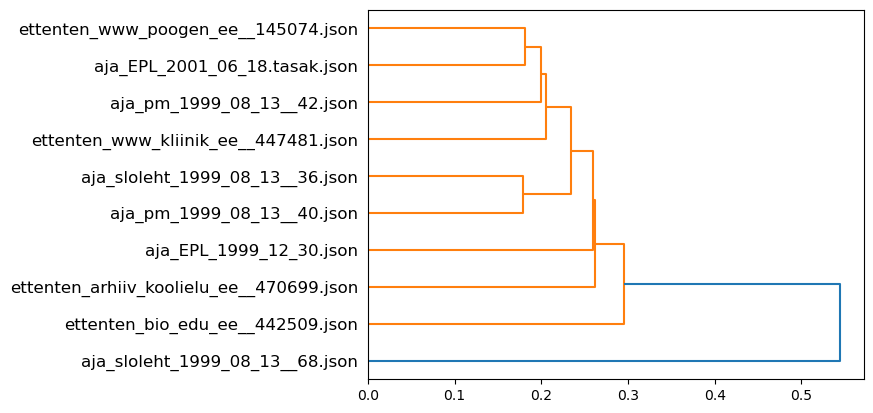

In [25]:
# 1) matplotlib'i joonistuse kuvamine Notebookis kuvada ilma 'show' vms käsuta. 
#%matplotlib inline

# 2) Loome dendrogrammi
from scipy.cluster.hierarchy import dendrogram
dendrogram(linkage_matrix, orientation="right", labels=filenames)

### Ülesanne 3. SL Õhtulehe artiklite "rubriigistamine" (2,5 p)

Looge programm, mis määrab SL Õhtulehe artiklitele rubriigid sarnaste PM ja EPL artiklite rubriikide alusel. Rubriik tuleb valida 6 normaliseeritud rubriiginime seast ('eesti_uudised', 'välisuudised', 'kultuur', 'arvamused', 'majandus', 'sport'), lisaks võib panna rubriigiks ka 'määramata' -- siis, kui tõenäosus õige rubriik määrata paistab olevat liiga väike.

Alustage programmi arendamist ja testimist kataloogi `'2_aja_EPL_pm_sloleht'` artiklite peal. Rubriigi määramiseks rakendage taaskord dokumentide sarnasuse leidmist, aga seekord kasutage vektoriseerijana klassi [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) . 

TfidfVectorizer kasutab sõnasageduste asemel **TF-IDF-skoori**, mis näitab, kuivõrd iseloomulik on sõna mingile tekstile korpuses. TF (_term frequency_) on sõna esinemissagedus tekstis, IDF (_inverse document frequency_) kajastab seda, kui paljudes korpuse dokumentides see sõna üldse esineb, TF-IDF on nende korrutis (toimeloogika täpsem kirjeldus [siin](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)).

Eeltöötluse võtted jäävad teie otsustada. Leidke iga SL Õhtulehe artikliga kõige sarnasemad Postimehe ja Eesti Päevalehe artiklid ning otsustage SL Õhtulehe artikli rubriik nende rubriikide põhjal. Milline on rubriigi määramise täpne loogika, jääb teie otsustada; võib nt katsetada [KNN algoritmi](http://www.saedsayad.com/k_nearest_neighbors.htm) tööpõhimõtet, kasutada mingit sarnasuste lävendit, millest väiksema sarnasuse korral jäetakse rubriik määramata, ja/või katsetada mõnd `sklearn`'i [masinõppelähenemist](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html) (aga arvestage, et masinõppe katsetamine võib olla üsna töömahukas ning otseselt seda nõutud ei ole).

Kui tunnete, et olete juba piisavalt kataloogi `'2_aja_EPL_pm_sloleht'` SL Õhtulehe artiklitel katsetanud ning paistab, et tulemused on ok, siis suurendage artiklite hulka, lisades sinna kataloogis `'3_aja_sloleht'` olevad artiklid. Pärast artiklite hulga suurendamist enam "rubriigistamise loogikat" muuta ei tohi -- meid huvitabki küsimus, kui hästi see loogika toimib ka uutel / tundmatutel andmetel.

Programmi väljastab kataloogis `'2_aja_EPL_pm_sloleht'` olevate SL Õhtulehe artiklite rubriigistamise tulemused (artiklipealkirjad + määratud rubriigid) ning samuti `'3_aja_sloleht'` artiklite rubriigistamise tulemused.

## Teemade modelleerimine

Lisaks klasterdamisalgoritmidele on dokumentide liigitamisel laialdaselt kasutusel **teemade modelleerimise** (*topic modeling*) algoritmid, neist enim kasutatud on [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).  Teemade modelleerimise eesmärk on anda ülevaade dokumentidest, et lugejal oleks võimalik ilma kõiki dokumente läbi lugemata saada aru, millest kirjutatakse. 

Teemade modelleerimine põhineb eeldusel, et **erinevatest teemadest kirjutades kasutatakse mingil määral erinevaid sõnu**. Nagu klasterdamine, on ka teemade modelleerimine juhendamata masinõppe valdkonda kuuluv ülesanne ehk me ei vaja märgendatud treeningkorpust. Teemade modelleerimise puhul leitakse aga korpusest esmalt seal esinevad teemad ehk sõnade tõenäosuslik jaotumine: iga teema puhul on erinevatel sõnadel erinev esinemise tõenäosus. 

Kui teemad on leitud, võime soovi korral ka leida, milline sõnade tõenäosuslik jaotus kirjeldab mingit dokumenti kõige paremini ehk saame selle põhjal dokumente liigitada. 

Et asjast paremini aru saada, teeme katset pisikese näidiskorpusega. Teemade modelleerimiseks kasutame [gensim](https://radimrehurek.com/gensim/index.html) teeki, mille 7. praktikumis juba installisime word2vec mudeli treenimiseks. 

Loome kõigepealt omale hästi naiivse näitekorpuse, kus sisalduvad tekstid (siinkohal ühelauselised) kahel eri teemal, milles kasutatav sõnavara ka selgelt erineb:

In [26]:
texts = ['Teemade modelleerimine põhineb eeldusel, et erinevatest teemadest kirjutades kasutatakse mingil määral erinevaid sõnu.',
         'Nagu klasterdamine, on ka teemade modelleerimine juhendamata masinõppe valdkonda kuuluv ülesanne ehk me ei vaja märgendatud treeningkorpust.',
         'Teemade modelleerimise puhul leitakse aga korpusest esmalt seal esinevad teemad ehk sõnade tõenäosuslik jaotumine: iga teema puhul on erinevatel sõnadel erinev esinemise tõenäosus.',
         'Makaronivorm tähendab ahjuvormi makaronidest.',
         'Makaronivorm küpsetatakse ahjus ahjuvormi sees.',
         'Makaronivormi põhilised koostisosad lisaks makaronidele on muna ja piima segu, maitseained ning juust katteks.']

Loome korpusest maatriksi nagu enne ajakirjandustekstidestki: kasutame ```CounteVectorizerit``` ning tokeniseerime teksti eelnevalt defineeritud ```tokenize_with_estnltk``` meetodiga.

In [27]:
vectorizer = CountVectorizer(tokenizer = tokenize_with_estnltk, token_pattern=None)
matrix = vectorizer.fit_transform(texts)

In [28]:
matrix

<6x70 sparse matrix of type '<class 'numpy.int64'>'
	with 85 stored elements in Compressed Sparse Row format>

Edasi impordime *gensimist* ```LdaModel```'i, mis on vajalik mudeli treenimiseks. Samuti on meil vaja ```Sparse2Corpus``` meetodit, mille abil oma hõre maatriks teisendada ```LdaModel```'ile sobivale kujule:

In [29]:
from gensim.models.ldamulticore import LdaModel
from gensim.matutils import Sparse2Corpus

In [30]:
corpus = Sparse2Corpus(matrix, documents_columns = False)

Samuti vajame teemade mudeli treenimiseks sõnastiku kujul id->sõna _mapping_'ut. Selleks leiame vektoriseerijast sõnavara ning loome selle põhjal sõnastiku, kus võtmeteks on indeksid ja väärtusteks sõnad:

In [31]:
vocab = np.array(vectorizer.get_feature_names_out())

id2word = {}
for idx, i in enumerate(vocab):
    id2word[idx] = i

Ja nüüd saamegi asuda mudeli treenimise juurde. Treenimiseks peame ette andma korpuse, teemade arvu ning id2word _mapping_'u. Teemade arv on vabalt valitav. Kuna praegusel juhul me teame, et neid on 2, siis võimegi selle valida, üldjuhul vajab see aga katsetamist, et näha, mis paistab optimaalne (ja loomulikult sõltub korpuse suurusest ja tekstide arvust - 6 lausest 60 teemat otsida ei ole mõtet, aga kui korpus on suur, siis ei ole 60 teemat midagi ulmelist). Alati tasub lähtuda muidugi oma eesmärkidest - teemade tõlgendamine jääb siin kasutaja teha ning suure teemade arvu korral on seda raske teha (samas võib liikuda edasi klasterdamisalgoritmide juurde, mis ka leitud teemasid grupeerida aitaks). 

In [32]:
lda = LdaModel(corpus, num_topics=2, id2word=id2word)

INFO:ldamodel.py:577: using symmetric alpha at 0.5
INFO:ldamodel.py:577: using symmetric eta at 0.5
INFO:ldamodel.py:482: using serial LDA version on this node
INFO:ldamodel.py:948: running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 6 documents, updating model once every 6 documents, evaluating perplexity every 6 documents, iterating 50x with a convergence threshold of 0.001000
INFO:ldamodel.py:848: -5.172 per-word bound, 36.1 perplexity estimate based on a held-out corpus of 6 documents with 86 words
INFO:ldamodel.py:1002: PROGRESS: pass 0, at document #6/6
INFO:ldamodel.py:1197: topic #0 (0.500): 0.053*"." + 0.030*"," + 0.026*"makaronivorm" + 0.025*"ahjuvormi" + 0.025*"on" + 0.021*"teemade" + 0.018*"sees" + 0.018*"ahjus" + 0.018*"küpsetatakse" + 0.018*"ning"
INFO:ldamodel.py:1197: topic #1 (0.500): 0.037*"." + 0.030*"teemade" + 0.029*"puhul" + 0.027*"on" + 0.023*"ehk" + 0.021*"," + 0.020*"modelleerimine" + 0.018*"iga" + 0.018*"teemad" + 0.018*"e

Kui mudel on treenitud, saame vaadata, missugused teemad moodustusid. Nagu öeldud, teema moodustab sõnade tõenäosuslik jaotus, seega näidatakse meile sõnu ja nende tõenäosusi. Kuna meil oli ainult 2 teemat, siis ütleme, et soovime neid mõlemat näha ning kummastki 10 esimest sõna:

In [33]:
lda.show_topics(2, 10)

[(0,
  '0.053*"." + 0.030*"," + 0.026*"makaronivorm" + 0.025*"ahjuvormi" + 0.025*"on" + 0.021*"teemade" + 0.018*"sees" + 0.018*"ahjus" + 0.018*"küpsetatakse" + 0.018*"ning"'),
 (1,
  '0.037*"." + 0.030*"teemade" + 0.029*"puhul" + 0.027*"on" + 0.023*"ehk" + 0.021*"," + 0.020*"modelleerimine" + 0.018*"iga" + 0.018*"teemad" + 0.018*"esmalt"')]

Näeme, et teemade esimesteks ehk n-ö kõige iseloomulikumateks "sõnadeks" on praegu mh kirjavahemärgid. Samuti korduvad esimesena paiknevad sõnad mõlemas teemas. See on selge vihje, et ühest küljest on meie korpus kaugelt liiga väike selle meetodi kasutamiseks, teisest küljest on meil tegemata eeltöötlus - teemasid modelleerides on üldiselt vaja välja visata n-ö stoppsõnad (keeles sageli esinevad sõnad, millel tähendust vähe, sh kirjavahemärgid, sidesõnad jne). Seda saab näiteks teha, andes ```CountVectorizer```'ile ette loendi stoppsõnadest parameetrina *stop_words*. Samuti on mõistlik oma tekst lemmatiseerida.

Kui oleme teemad leidnud, saame küsida ka, millised tekstid kuuluvad millise teema alla. Selleks leiame kõigi tekstide skoorid erinevate teemade alla kuulumiseks:

In [34]:
assignments = lda.inference(corpus)

Saime tuple'i, mille esimene liige on numpy array, milles igal real on ühe teksti skoorid. Leiame neist suurimad, et saada teada, millise teema alla mingi tekst mudeli meelest kõige suurema tõenäosusega kuulub:

In [35]:
# argmax() leiab suurima väärtusega elemendi indeksi ning axis = 1 täpsustab, et vaatame rea kaupa
most_likely_labels = assignments[0].argmax(axis=1)

In [36]:
most_likely_labels

array([1, 0, 1, 0, 0, 0], dtype=int64)

Saadud 0-d ja 1-d tähistavad, kumma teema alla vastava indeksiga tekst kuulub praeguse mudeli järgi. 

Kuna meie korpus on väike ja eeltöötlemata ehk enamik sõnu esineb ühe korra ning mudeli algväärtustamine juhuslik, siis erinevatel jooksutamistel saame erinevaid tulemusi. Päris andmetega töötades see nii olla ei tohiks ja mudel peaks end ära stabiliseerima ka vaikeparameetritega. Kui see nii ei ole, siis saab vajadusel suurendada seda, mitu korda korpust läbi käiakse ja teemasid üle arvutatakse, enne kui mudeli treenimine lõppeb. Selle kohta leiab soovi korral rohkem infot [siit](https://radimrehurek.com/gensim/models/ldamodel.html). 

### Ülesanne 4. Teemad Eesti uudistes (1,75 p)

Looge teemade mudel Eesti uudistele. Selleks kasutage kataloogist '2_aja_EPL_pm_sloleht' uudiseid, mille rubriigiks on märgitud "eesti_uudised". 
* Tehke uudistele eeltöötlus, mille käigus need lemmatiseeritakse ning eemaldatakse stoppsõnad. Stoppsõnade seas peaksid kindlasti olema ka kirjavahemärgid.
* Vektoriseerijana kasutage ```CountVectorizer```'it. Kuna LDA mudel vajab sisendina sõnade esinemissagedusi korpuse tekstides, siis ```TfidfVectorizer``` ei sobi.
* Katsetades erinevate teemade arvudega, leidke enda meelest optimaalne. 
* Leidke ka iga teema alla kuuluvad uudised ning väljastage ekraanile nende algus (nt 200 tähemärki).
* Soovi korral võite proovida ka näiteks ainult mingite sõnaliikide peal mudelit treenida.

### Veel TF-IDF-ist

Lugedes ülesande 3 juurest TF-IDF-skoori kirjeldust, võis tekkida ülesandes 4 kiusatus kasutada TfidfVectorizerit, kuna teemade väljaselgitamiseks oleks ju tore arvestada just sellele tekstile iseloomulikke sõnu. LDA toimib aga sõnasageduste pealt, seega tuleks sel juhul kasutada mõnda teist teemade modelleerimise algoritmi. 

See ei tähenda aga, et me ei võiks TF-IDFi sellegipoolest oma tekstide uurimiseks kasutada, kui me juhtumisi juba teame tekstide liigitust, ent tahaks teada, mille poolest liigid üksteisest erinevad. Võtame selleks eelnevas näites kasutatud korpuse, ent jagame tekstid vastavalt liiki kuuluvusele kaheks:

In [37]:
type1 = ' '.join(texts[:3])
type2 = ' '.join(texts[3:])

In [38]:
corpus = [type1, type2]

In [39]:
corpus

['Teemade modelleerimine põhineb eeldusel, et erinevatest teemadest kirjutades kasutatakse mingil määral erinevaid sõnu. Nagu klasterdamine, on ka teemade modelleerimine juhendamata masinõppe valdkonda kuuluv ülesanne ehk me ei vaja märgendatud treeningkorpust. Teemade modelleerimise puhul leitakse aga korpusest esmalt seal esinevad teemad ehk sõnade tõenäosuslik jaotumine: iga teema puhul on erinevatel sõnadel erinev esinemise tõenäosus.',
 'Makaronivorm tähendab ahjuvormi makaronidest. Makaronivorm küpsetatakse ahjus ahjuvormi sees. Makaronivormi põhilised koostisosad lisaks makaronidele on muna ja piima segu, maitseained ning juust katteks.']

Loome TfIdf-vektoriseerija ja maatriksi ning salvestame sõnavara:

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer = tokenize_with_estnltk, token_pattern=None)
matrix = vectorizer.fit_transform(corpus)
vocab = np.array(vectorizer.get_feature_names_out())

Saadud maatriksis on kõigi sõnade Tf-Idf skoorid meie mõlemas tekstis. Suurimate skooridega sõnad on kummagi vastava teksti jaoks kõige iseloomulikumad. Et maatriksit vaadata, tekitame temast tiheda maatriksi:

In [41]:
dense_matrix = matrix.todense()
dense_matrix

matrix([[0.1670026 , 0.2505039 , 0.11735816, 0.11735816, 0.        ,
         0.        , 0.11735816, 0.23471633, 0.11735816, 0.11735816,
         0.11735816, 0.11735816, 0.11735816, 0.11735816, 0.11735816,
         0.11735816, 0.11735816, 0.11735816, 0.        , 0.11735816,
         0.11735816, 0.        , 0.11735816, 0.11735816, 0.        ,
         0.11735816, 0.11735816, 0.        , 0.11735816, 0.11735816,
         0.        , 0.11735816, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.11735816, 0.11735816,
         0.11735816, 0.23471633, 0.11735816, 0.        , 0.11735816,
         0.11735816, 0.11735816, 0.        , 0.1670026 , 0.        ,
         0.23471633, 0.        , 0.11735816, 0.11735816, 0.        ,
         0.        , 0.11735816, 0.11735816, 0.11735816, 0.11735816,
         0.11735816, 0.35207449, 0.11735816, 0.11735816, 0.        ,
         0.11735816, 0.11735816, 0.11735816, 0.11735816, 0.11735816],
        [0.1266344 , 0.3799032 , 

Et teada saada, millised sõnad kõige suurematele väärtustele maatriksis vastavad, loome muutuja *sorted_scores*, kus maatriksi indeksid on sorteeritud vastavalt nende väärtustele, ning teeme selle listiks. 

In [42]:
sorted_scores = dense_matrix.argsort(axis = 1).tolist()
sorted_scores

[[34,
  35,
  33,
  32,
  30,
  43,
  27,
  24,
  47,
  21,
  49,
  51,
  36,
  54,
  18,
  37,
  4,
  5,
  64,
  55,
  67,
  39,
  66,
  65,
  40,
  42,
  56,
  63,
  46,
  62,
  60,
  59,
  58,
  57,
  52,
  53,
  45,
  44,
  69,
  68,
  2,
  3,
  6,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  38,
  16,
  15,
  19,
  31,
  20,
  29,
  22,
  23,
  25,
  26,
  17,
  28,
  0,
  48,
  41,
  50,
  7,
  1,
  61],
 [69,
  26,
  60,
  28,
  29,
  59,
  31,
  58,
  57,
  68,
  25,
  56,
  52,
  38,
  39,
  40,
  41,
  42,
  50,
  44,
  45,
  53,
  61,
  23,
  22,
  67,
  2,
  3,
  66,
  65,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  63,
  19,
  20,
  62,
  46,
  48,
  0,
  49,
  4,
  64,
  18,
  21,
  24,
  27,
  47,
  32,
  30,
  35,
  55,
  54,
  37,
  51,
  43,
  33,
  34,
  36,
  5,
  1]]

Nüüd saamegi leida kummalegi tekstile kõige iseloomulikumad sõnad:

In [43]:
for idx, scores in enumerate(sorted_scores):
    print('Teksti ', str(idx+1), ' kõige enam teis(t)est eristavad sõnad on : ' )
    print()
    # Leiame 10 viimase ehk kõige iseloomulikuma sõna indeksit ning pöörame nad ümber,
    # et 1. kohal oleks kõige iseloomulikum
    max_values = scores[-10:][::-1]
    
    # Prindime vastavate indeksitega sõnad
    for i in max_values:
        print(vocab[i])
    print()    
    print('----------') 
    print()

Teksti  1  kõige enam teis(t)est eristavad sõnad on : 

teemade
.
ehk
puhul
modelleerimine
on
,
korpusest
iga
klasterdamine

----------

Teksti  2  kõige enam teis(t)est eristavad sõnad on : 

.
ahjuvormi
makaronivorm
makaronidele
maitseained
muna
põhilised
makaronivormi
sees
segu

----------



Loomulikult oleks siingi abi lemmatiseerimisest. 

---

## Lisamaterjal (vabatahtlik). Optiline tekstituvastus

Optiline tekstituvastus ehk OCR (_Optical Character Recognition_) tegeleb piltide pealt teksti tuvastamise ja masinloetavale kujule viimisega. Näiteks võimaldab see analüüsida digiteeritud kujul vanu ürikuid ja ajalehti ning muuta nendel olev tekst märksõnade kaudu otsitavaks. Siiski on raske leida tekstituvastussüsteemi, mis töötaks ühtviisi hästi igat liiki tekstidel. Tüüpiliselt vajab süsteem spetsiaalset kohandamist: nii konkreetsele keelele kui ka analüüsitavatele kirjašriftidele. Tegemist on keeruka protsessiga ning selleks vajaminevad teadmised ja oskused ei mahu käesoleva aine raamesse. Siiski on Pythonis olemas ka teegid, mis võimaldavad ilma suurema *know-how*'ta lihtsamaid probleeme lahendada. Head tagasisidet on saanud näiteks [PyTesseract](https://pypi.python.org/pypi/pytesseract), mis on Pythoni *wrapper* Google'i *Tesseract-OCR* API-le. Käesolevas praktikumis katsetamegi _PyTesseract_-i.

1) Installige Google'i [Tesseract-OCR](https://tesseract-ocr.github.io/tessdoc/Installation.html); Windows'i installeriga installides pakutakse teile installitavate komponentide valikut: valige kindlasti keelte seast _"Estonian"_, lisakatsetamiseks on soovitav võtta ka _"Finnish"_;

2) Installige käsurealt [PyTesseract](https://pypi.python.org/pypi/pytesseract):

       pip install pytesseract

3) Katsetage järgmisi koodilõike (loodud [selle kasutusnäite](https://pypi.python.org/pypi/pytesseract) eeskujul):

In [44]:
try:
    import Image
except ImportError:
    from PIL import Image
import pytesseract

#pytesseract.pytesseract.tesseract_cmd = '<full_path_to_your_tesseract_executable>'
#pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract'

**test-ocr-pm-1.png**
<img src="test-ocr-pm-1.png">

In [45]:
print(pytesseract.image_to_string(Image.open('test-ocr-pm-1.png'), lang='est'))

 

Võõra auto tõstuki
otsa tõstnud Lembit
selgitab: kõik sai alguse
meie ettevõtte autode
süütamisest



**test-ocr-kinematografistid-1.png**
<img src="test-ocr-kinematografistid-1.png">

In [46]:
print(pytesseract.image_to_string(Image.open('test-ocr-kinematografistid-1.png'), lang='est'))

Esimeselt üleliiduliselt noor-
te kinematografistide tööde
ülevaatuselt Kiievis tuli eesti
noor filmiloojate põlvkond ta-
gasi kolme auhinnaga. Diplo-
mi parima = täismetraažilise
mängufilmi eest sai 0. Neu-
land filmiga «Tuulte pesa».



In [47]:
print(pytesseract.image_to_string(Image.open('test-ocr-kinematografistid-1.png'), lang='fin'))

Esimeselt äleliiduliselt noor-
te kinematografistide tööde
lilevaatuselt Kiievis tuli eesti
noor filmiloojate pölvkond ta-
gasi kolme auhinnaga. Diplo-
mi parima täismetraaZilise
mängufilmi eest sai O. Neu-
land filmiga <«Tuulte pesa».



### Boonusülesanne. OCR-i katsetamine (1.25p)

Otsige mingi pildi kujul tekst mõnest digiteeritud vanast ajalehest või ajakirjast (üks võimalus on pilt otsida nt http://www.digar.ee andmebaasist).
Katsetage sellel *PyTesseract*'i teegi tekstituvastust. Et tuvastamine maksimaalselt õnnestuks, tasuks valida pilt, millel on valge taust ning tekst on otse. Samuti peaks kirjašrift olema võimalikult sarnane tänapäevastele ajalehešriftidele -- gooti kirja tuvastamine teil tõenäoliselt ei õnnestu. Lahendusena esitage kood, pilt *Notebook*'is ning pildilt tuvastatud tekst. 

---

#### Märkus

Käesoleva praktikumi materjalide loomisel on osaliselt tuginetud veebikursuse _'Text Analysis with Topic Models for the Humanities and Social Sciences'_ materjalidele, mis on saadaval leheküljel: https://github.com/DARIAH-DE/tatom/blob/develop/source/working_with_text.rst .